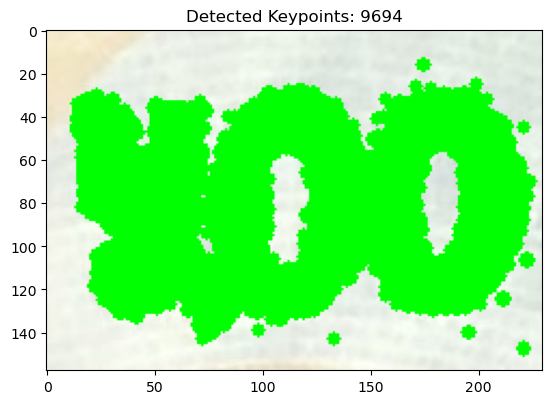

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Helper function to calculate image gradient
def image_gradient(image):
    Ix = np.zeros_like(image)
    Iy = np.zeros_like(image)
    
    Ix[:, 1:-1] = image[:, 2:] - image[:, :-2]
    Iy[1:-1, :] = image[2:, :] - image[:-2, :]
    
    return Ix, Iy

# FAST Keypoint Detector
def detect_fast_keypoints(image, threshold=10):
  
    keypoints = []
    h, w = image.shape
    
    # Define offsets for 16 surrounding pixels in a circle
    circle_offsets = [(0, -3), (1, -3), (2, -2), (3, -1), (3, 0), (3, 1), (2, 2), (1, 3),
                      (0, 3), (-1, 3), (-2, 2), (-3, 1), (-3, 0), (-3, -1), (-2, -2), (-1, -3)]
    
    for y in range(3, h - 3):
        for x in range(3, w - 3):
            center_pixel = image[y, x]
            circle_pixels = [image[y + dy, x + dx] for dx, dy in circle_offsets]
            
            # Threshold comparison for bright and dark surrounding pixels
            brighter = [1 if p > center_pixel + threshold else 0 for p in circle_pixels]
            darker = [1 if p < center_pixel - threshold else 0 for p in circle_pixels]
            
            # A keypoint is detected if 9 contiguous pixels are all brighter or darker
            if sum(brighter) >= 9 or sum(darker) >= 9:
                keypoints.append((x, y))
    
    return keypoints

# Harris corner response function for keypoint ranking
def harris_corner_response(image, window_size=3, k=0.04):
    Ix, Iy = image_gradient(image)
    
    Ix2 = Ix ** 2
    Iy2 = Iy ** 2
    Ixy = Ix * Iy
    
    height, width = image.shape
    response = np.zeros_like(image, dtype=float)
    
    for y in range(window_size//2, height - window_size//2):
        for x in range(window_size//2, width - window_size//2):
            window_ix2 = Ix2[y - window_size//2 : y + window_size//2 + 1, x - window_size//2 : x + window_size//2 + 1]
            window_iy2 = Iy2[y - window_size//2 : y + window_size//2 + 1, x - window_size//2 + 1 : x + window_size//2 + 1]
            window_ixy = Ixy[y - window_size//2 : y + window_size//2 + 1, x - window_size//2 : x + window_size//2 + 1]
            
            sum_ix2 = np.sum(window_ix2)
            sum_iy2 = np.sum(window_iy2)
            sum_ixy = np.sum(window_ixy)
            
            # Harris corner response formula
            det = (sum_ix2 * sum_iy2) - (sum_ixy ** 2)
            trace = sum_ix2 + sum_iy2
            response[y, x] = det - k * (trace ** 2)
    
    return response

# Assign orientation to keypoints
def assign_orientation(image, keypoints):
    oriented_keypoints = []
    
    for x, y in keypoints:
        patch = image[y-3:y+4, x-3:x+4]  # 7x7 patch around the keypoint
        Ix, Iy = image_gradient(patch)
        
        # Calculate the gradient orientation using moments
        moment_x = np.sum(Ix)
        moment_y = np.sum(Iy)
        
        angle = np.arctan2(moment_y, moment_x)  # Orientation angle
        oriented_keypoints.append((x, y, angle))
    
    return oriented_keypoints

# BRIEF Descriptor
def brief_descriptor(image, keypoints, patch_size=9):
    """
    Generates BRIEF descriptors for each keypoint by comparing pixel intensities within a patch.
    """
    descriptors = []
    keypoints_with_descriptor = []
    
    for kp in keypoints:
        x, y, angle = kp
        
        if x - patch_size//2 < 0 or x + patch_size//2 >= image.shape[1] or y - patch_size//2 < 0 or y + patch_size//2 >= image.shape[0]:
            continue  # Skip keypoints near the image border
        
        patch = image[y - patch_size//2 : y + patch_size//2 + 1, x - patch_size//2 : x + patch_size//2 + 1]
        descriptor = []
        
        # Compare pairs of random pixels in the patch
        for _ in range(128):  # 128-bit descriptor
            p1 = (np.random.randint(0, patch_size), np.random.randint(0, patch_size))
            p2 = (np.random.randint(0, patch_size), np.random.randint(0, patch_size))
            
            # BRIEF: compare pixel intensities
            descriptor.append(1 if patch[p1] > patch[p2] else 0)
        
        descriptors.append(descriptor)
        keypoints_with_descriptor.append(kp)
    
    return keypoints_with_descriptor, np.array(descriptors)

# Main function for ORB-like feature detection
def orb_like_detection(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 1. Detect keypoints using FAST
    keypoints = detect_fast_keypoints(image_gray)
    
    # 2. Rank keypoints using Harris corner response
    harris_response = harris_corner_response(image_gray)
    keypoints = sorted(keypoints, key=lambda pt: harris_response[pt[1], pt[0]], reverse=True)
    
    # 3. Assign orientation to keypoints
    oriented_keypoints = assign_orientation(image_gray, keypoints)
    
    # 4. Compute BRIEF descriptors
    keypoints_with_descriptor, descriptors = brief_descriptor(image_gray, oriented_keypoints)
    
    return keypoints_with_descriptor, descriptors

# Load image and run ORB-like detection
image = cv2.imread('1.jpg')  # Change to the path of your image
keypoints_with_descriptor, descriptors = orb_like_detection(image)

# Visualization of keypoints
for kp in keypoints_with_descriptor:
    x, y, _ = kp
    cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f'Detected Keypoints: {len(keypoints_with_descriptor)}')
plt.show()
